In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from nilearn.glm.first_level.hemodynamic_models import glover_hrf
from scipy import stats
from numpy.linalg import inv

# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'

EXPERIMENTS = {
    'MOTOR'      : {'runs': [5,6],   'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'runs': [7,8],   'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'runs': [9,10],  'cond':['fear','neut']},
    'GAMBLING'   : {'runs': [11,12], 'cond':['loss','win']},
    'LANGUAGE'   : {'runs': [13,14], 'cond':['math','story']},
    'RELATIONAL' : {'runs': [15,16], 'cond':['match','relation']},
    'SOCIAL'     : {'runs': [17,18], 'cond':['mental','rnd']}
}

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)


regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)





In [19]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int):      0-based subject ID to load
    experiment (str):   Name of experiment 
    run (int):          0-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = EXPERIMENTS[experiment]['runs'][run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (int): 0-based subject ID to load
    experiment (str) : Name of experiment

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = 'tfMRI_'+experiment+'_'+['RL','LR'][run]
  for cond in EXPERIMENTS[experiment]['cond']:    
    ev_file  = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list



In [20]:
TR = 0.72
osf = 2
length_hrf = 32  # sec

canonical_hrf = glover_hrf(tr=TR, oversampling=osf, time_length=length_hrf, onset=0)
canonical_hrf /= canonical_hrf.max()




def betaCoeffsRun1(hrf):
  betaCoefficientsLoss = []
  betaCoefficientsWin = []
  
  for i in range(len(subjects)):
    
    my_exp  = 'GAMBLING'
    my_subj = i
    my_run  = 0
    evs = load_evs(subject=my_subj, experiment=my_exp,run=my_run)
    onsets_loss = np.concatenate((evs[0][0] , evs[0][1]))
    onsets_win = np.concatenate((evs[1][0] , evs[1][1]))


    canonical_hrf = hrf
    data = load_single_timeseries(subject=my_subj,experiment=my_exp,run=my_run,remove_mean=True)

    predictor_loss = np.zeros(len(data[0]))
    predictor_loss[onsets_loss] = 1
    
    predictor_win = np.zeros(len(data[0]))
    predictor_win[onsets_win] = 1

    predictor_convLoss = np.convolve(predictor_loss.squeeze(), canonical_hrf)
    predictor_convLoss = predictor_convLoss[:predictor_loss.size]
    predictor_convLoss = predictor_convLoss[:, np.newaxis]
    
    predictor_convWin = np.convolve(predictor_win.squeeze(), canonical_hrf)
    predictor_convWin = predictor_convWin[:predictor_win.size]
    predictor_convWin = predictor_convWin[:, np.newaxis]
    

    betaCoeffForPersonLoss = []
    betaCoeffForPersonWin = []

    for k in range(len(data)):
     
      intercept = np.ones((predictor_convLoss.size, 1))
      X_conv = np.hstack((intercept, predictor_convLoss,predictor_convWin))
      betas_conv = inv(X_conv.T @ X_conv) @ X_conv.T @ data[k]
      betaCoeffForPersonLoss.append(betas_conv[1])
      betaCoeffForPersonWin.append(betas_conv[2])
    
    betaCoefficientsLoss.append(betaCoeffForPersonLoss)
    betaCoefficientsWin.append(betaCoeffForPersonWin)
  
  return betaCoefficientsLoss , betaCoefficientsWin

betasLoss , betasWin = betaCoeffsRun1(canonical_hrf)

betasLoss = np.array(betasLoss)

betasWin = np.array(betasWin)

print(f'shape of betasWin: {betasWin.shape} , shape of betasLoss: {betasLoss.shape}')




    


      












shape of betasWin: (339, 360) , shape of betasLoss: (339, 360)


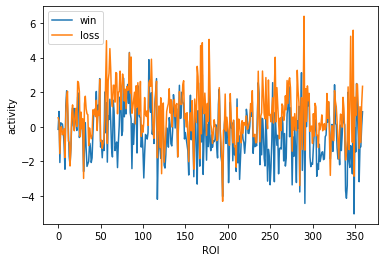

In [21]:
plt.plot(betasWin[1],label='win')
plt.plot(betasLoss[1],label='loss')
plt.xlabel('ROI')
plt.ylabel('activity')
plt.legend()

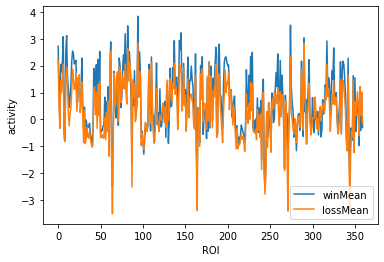

In [23]:
betasWinMean = np.mean(betasWin , axis = 0)

betasLossMean = np.mean(betasLoss , axis = 0)

plt.plot(betasWinMean,label='winMean')
plt.plot(betasLossMean,label='lossMean')
plt.xlabel('ROI')
plt.ylabel('activity')
plt.legend()

In [24]:
from scipy import stats
stats.ttest_ind(betasWinMean, betasLossMean)

Ttest_indResult(statistic=3.8170751637416296, pvalue=0.00014669382583061297)

In [25]:
np.save('betasWinMean' , betasWinMean)
np.save('betasLossMean' , betasLossMean)

shape of betasWin: (339, 360) , shape of betasLoss: (339, 360)


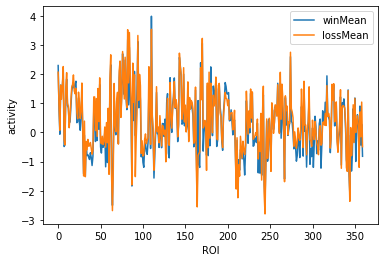

In [26]:
TR = 0.72
osf = 2
length_hrf = 32  # sec

canonical_hrf = glover_hrf(tr=TR, oversampling=osf, time_length=length_hrf, onset=0)
canonical_hrf /= canonical_hrf.max()




def betaCoeffsRun2(hrf):
  betaCoefficientsLoss = []
  betaCoefficientsWin = []
  
  for i in range(len(subjects)):
    
    my_exp  = 'GAMBLING'
    my_subj = i
    my_run  = 1
    evs = load_evs(subject=my_subj, experiment=my_exp,run=my_run)
    onsets_loss = np.concatenate((evs[0][0] , evs[0][1]))
    onsets_win = np.concatenate((evs[1][0] , evs[1][1]))


    canonical_hrf = hrf
    data = load_single_timeseries(subject=my_subj,experiment=my_exp,run=my_run,remove_mean=True)

    predictor_loss = np.zeros(len(data[0]))
    predictor_loss[onsets_loss] = 1
    
    predictor_win = np.zeros(len(data[0]))
    predictor_win[onsets_win] = 1

    predictor_convLoss = np.convolve(predictor_loss.squeeze(), canonical_hrf)
    predictor_convLoss = predictor_convLoss[:predictor_loss.size]
    predictor_convLoss = predictor_convLoss[:, np.newaxis]
    
    predictor_convWin = np.convolve(predictor_win.squeeze(), canonical_hrf)
    predictor_convWin = predictor_convWin[:predictor_win.size]
    predictor_convWin = predictor_convWin[:, np.newaxis]
    

    betaCoeffForPersonLoss = []
    betaCoeffForPersonWin = []

    for k in range(len(data)):
     
      intercept = np.ones((predictor_convLoss.size, 1))
      X_conv = np.hstack((intercept, predictor_convLoss,predictor_convWin))
      betas_conv = inv(X_conv.T @ X_conv) @ X_conv.T @ data[k]
      betaCoeffForPersonLoss.append(betas_conv[1])
      betaCoeffForPersonWin.append(betas_conv[2])
    
    betaCoefficientsLoss.append(betaCoeffForPersonLoss)
    betaCoefficientsWin.append(betaCoeffForPersonWin)
  
  return betaCoefficientsLoss , betaCoefficientsWin

betasLoss2 , betasWin2 = betaCoeffsRun2(canonical_hrf)

betasLoss2 = np.array(betasLoss2)

betasWin2 = np.array(betasWin2)

print(f'shape of betasWin: {betasWin2.shape} , shape of betasLoss: {betasLoss2.shape}')




    


      
betasWinMean2 = np.mean(betasWin2 , axis = 0)

betasLossMean2 = np.mean(betasLoss2 , axis = 0)

plt.plot(betasWinMean2,label='winMean')
plt.plot(betasLossMean2,label='lossMean')
plt.xlabel('ROI')
plt.ylabel('activity')
plt.legend()











In [27]:
stats.ttest_ind(betasWinMean2, betasLossMean2)

Ttest_indResult(statistic=-1.5912473717200435, pvalue=0.11199407108277244)

In [33]:
run0 = np.array([[0, 1], [4, 5]])
run1 = np.array([[2, 7], [0, 1]])
np.mean(np.array([ old_set, new_set ]), axis=0 )


array([[1., 4.],
       [2., 3.]])

In [35]:
betasWinRun0 =betasWin
betasWinRun1 = betasWin2

betasMeanRunWin_all = np.mean(np.array([ betasWinRun0, betasWinRun1 ]), axis=0 )

betasLossRun0 = betasLoss
betasLossRun1 = betasLoss2

betasMeanRunLoss_all = np.mean(np.array([ betasLossRun0, betasLossRun1 ]), axis=0 )

print(f'shape of betas Win is {betasMeanRunWin_all.shape} , shape of betas Loss is  {betasMeanRunLoss_all.shape}')

shape of betas Win is (339, 360) , shape of betas Loss is  (339, 360)


In [36]:
      
betasWinMeanAll = np.mean(betasMeanRunWin_all , axis = 0)

betasLossMeanAll = np.mean(betasMeanRunLoss_all , axis = 0)

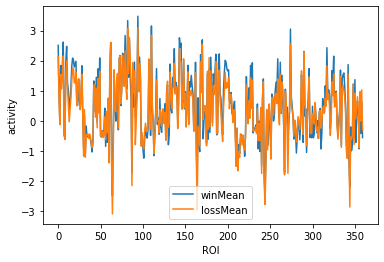

In [37]:
plt.plot(betasWinMeanAll,label='winMean')
plt.plot(betasLossMeanAll,label='lossMean')
plt.xlabel('ROI')
plt.ylabel('activity')
plt.legend()

In [38]:
stats.ttest_ind(betasWinMeanAll, betasLossMeanAll)

Ttest_indResult(statistic=1.1999661038727762, pvalue=0.23054829316456021)

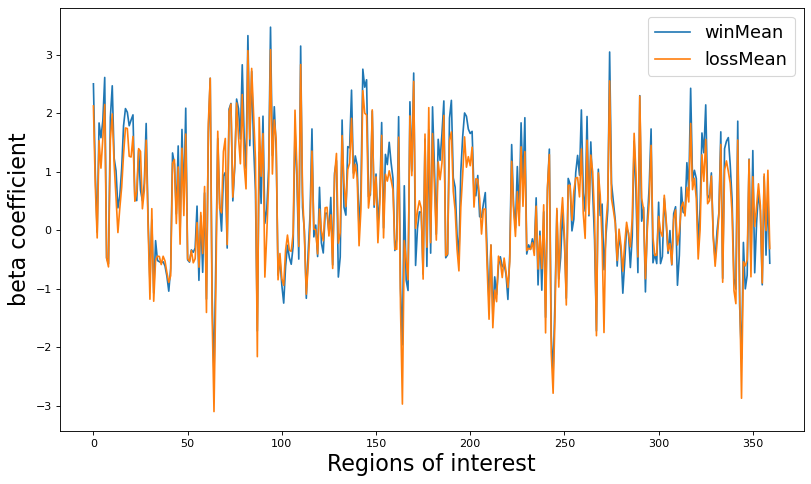

In [53]:
avgWin = (betasWin + betasWin2) / 2
betasWinMeanAll = np.mean(avgWin , axis = 0)
from matplotlib.pyplot import figure

figure(figsize=(12, 7), dpi=80)

avgLoss = (betasLoss + betasLoss2) / 2

betasLossMeanAll = np.mean(avgLoss , axis = 0)
plt.plot(betasWinMeanAll,label='winMean')
plt.plot(betasLossMeanAll,label='lossMean')
plt.xlabel('Regions of interest' , size = 20)
plt.ylabel('beta coefficient' , size = 20)
plt.legend(loc='best'  ,prop={"size":16})

In [41]:
np.save('betasAverageWin' ,avgWin)
np.save('betasAverageLoss' , avgLoss)